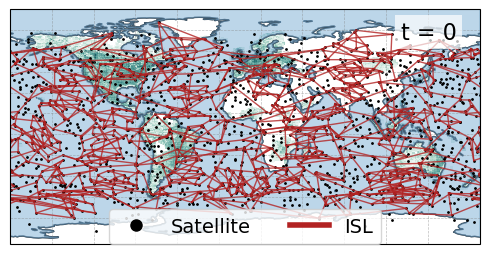


Timestamp 0 statistics:
Total inter-cell ISLs: 525
Total intra-cell ISLs: sum([3, 4, 8, 7, 4, 19, 10, 14, 10, 10, 3, 4, 3, 4, 10, 4, 10, 4, 9, 4, 10, 10, 4, 17, 14, 10, 4, 17, 17, 23, 23, 8, 8, 16, 16, 11, 18, 19, 5, 12, 10, 4, 13, 8, 21, 4, 11, 6, 9, 5, 12, 10, 4, 13, 8, 21, 18, 18, 6, 9, 5, 22, 22, 11, 11, 4, 13, 11, 16, 17, 17, 24, 11, 6, 4, 4, 7, 4, 4, 17, 5, 5, 24, 13, 6, 32, 32, 5, 17, 17, 4, 4, 6, 5, 5, 7, 7, 3, 3])
Generated visualization for timestamp 0


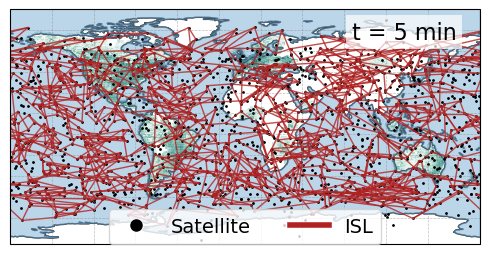


Timestamp 5 statistics:
Total inter-cell ISLs: 522
Total intra-cell ISLs: sum([14, 4, 8, 3, 4, 7, 19, 10, 10, 3, 3, 4, 10, 10, 4, 17, 4, 23, 4, 10, 9, 4, 23, 10, 10, 8, 8, 10, 4, 14, 17, 16, 11, 4, 5, 19, 12, 4, 16, 18, 17, 10, 13, 10, 10, 21, 4, 18, 9, 18, 9, 6, 12, 19, 19, 10, 4, 13, 11, 4, 21, 13, 7, 6, 17, 17, 5, 9, 24, 5, 11, 4, 4, 16, 17, 11, 5, 11, 6, 6, 4, 4, 32, 5, 17, 4, 5, 24, 4, 5, 13, 6, 5, 32, 3, 3, 7, 7, 17])
Generated visualization for timestamp 5


In [1]:
# Visualize Starlink satellite topology and population density

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.ticker import FixedLocator, FuncFormatter
from tqdm import tqdm

def create_grid_boundaries():
    """Create 11x11 grid boundaries for map overlay"""
    lat_boundaries = []
    lon_boundaries = []

    lat = 90
    for i in range(11):
        if i < 10:
            lat_boundaries.append((lat, lat - 16))
            lat -= 16
        else:
            lat_boundaries.append((lat, -90))

    lon = -180
    for i in range(11):
        if i < 10:
            lon_boundaries.append((lon, lon + 32))
            lon += 32
        else:
            lon_boundaries.append((lon, 180))

    return lat_boundaries, lon_boundaries

def process_density_data(density_file):
    """Convert raw density data into a 45x90 grid"""
    density_data = np.load(density_file, allow_pickle=True)
    density_grid = np.zeros((45, 90))
    for item in density_data:
        lat_idx = int((90 - item['lat_lon'][0]) // 4)
        lon_idx = int((item['lat_lon'][1] + 180) // 4)
        if lat_idx < 45 and lon_idx < 90:
            density_grid[lat_idx, lon_idx] = item['density']
    return density_grid

def load_data(satellite_data_file):
    """Load traffic, satellite, and coverage data"""
    supply_data = np.load(satellite_data_file, allow_pickle=True)
    satellite_locations = {t: {} for t in range(len(supply_data[0][3]))}
    for idx, data in enumerate(supply_data):
        param, random_numbers, cover, sat_location, _ = data
        for t in range(len(sat_location)):
            satellite_locations[t][idx] = sat_location[t]

    return satellite_locations

def plot_topology(timestamp, satellite_locations, all_inter_topology, all_intra_topology, plot_demands, output_file):
    """Plot satellite positions, ISLs, and demand heatmap at given timestamp"""

    # Color map for population demand
    color_str = '#ffffff,#b4d9cc,#89c0b6,#63a6a0,#448c8a,#287274,#0d585f'
    cmap_colors = color_str.split(',')
    color_list = [plt.cm.colors.hex2color(color) for color in cmap_colors]
    norm = Normalize(vmin=0, vmax=16)
    colors = [(v/16, c) for v, c in zip(np.linspace(0, 16, len(cmap_colors)), color_list)]
    cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

    fig, ax = plt.subplots(figsize=(5, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature(
        'physical', 'ocean', '110m', edgecolor='face', facecolor='#7BAED5', alpha=0.5))

    # Draw demand heatmap
    gap = 0.5
    lats, lons, values = zip(*[(lat - gap/2, lon + gap/2, value)
                               for (lat, lon), value in plot_demands.items()])
    plt.scatter(lons, lats, c=values, cmap=cmap, norm=norm,
                marker='s', s=5, edgecolor='none', alpha=0.75,
                transform=ccrs.PlateCarree())

    def plot_isl_connection(lon1, lat1, lon2, lat2):
        """Plot curved ISL line, accounting for dateline crossing"""
        lon1 = ((lon1 + 180) % 360) - 180
        lon2 = ((lon2 + 180) % 360) - 180
        if abs(lon1 - lon2) > 180:
            lon2 += -360 if lon1 < lon2 else 360
        plt.plot([lon1, lon2], [lat1, lat2], color='firebrick',
                 linewidth=1, alpha=0.8, transform=ccrs.PlateCarree())

    # Plot satellite positions
    sat_positions = satellite_locations[timestamp]
    for lon, lat in sat_positions.values():
        lon_deg = ((np.degrees(lon) + 180) % 360) - 180
        lat_deg = np.degrees(lat)
        plt.plot(lon_deg, lat_deg, marker='.', markersize=2,
                 transform=ccrs.Geodetic(), color='#000000', alpha=1)

    # Plot intra-cell ISLs
    for connections in all_intra_topology[timestamp].values():
        for node1, node2 in connections:
            sat1, sat2 = node1 % len(sat_positions), node2 % len(sat_positions)
            if sat1 in sat_positions and sat2 in sat_positions:
                lon1, lat1 = sat_positions[sat1]
                lon2, lat2 = sat_positions[sat2]
                plot_isl_connection(np.degrees(lon1), np.degrees(lat1),
                                    np.degrees(lon2), np.degrees(lat2))

    # Plot inter-cell ISLs
    for (node1, node2), _ in all_inter_topology[timestamp]:
        sat1, sat2 = node1 % len(sat_positions), node2 % len(sat_positions)
        if sat1 in sat_positions and sat2 in sat_positions:
            lon1, lat1 = sat_positions[sat1]
            lon2, lat2 = sat_positions[sat2]
            plot_isl_connection(np.degrees(lon1), np.degrees(lat1),
                                np.degrees(lon2), np.degrees(lat2))

    # Add grid lines
    lat_bounds, lon_bounds = create_grid_boundaries()
    for lon_start, _ in lon_bounds:
        if lon_start != 180:
            plt.plot([lon_start, lon_start], [-90, 90], color='gray',
                     linestyle='--', linewidth=0.5, alpha=0.5, transform=ccrs.PlateCarree())
    for lat_start, _ in lat_bounds:
        if lat_start != -90:
            plt.plot([-180, 180], [lat_start, lat_start], color='gray',
                     linestyle='--', linewidth=0.5, alpha=0.5, transform=ccrs.PlateCarree())

    # Legend and time annotation
    legend_elements = [
        Line2D([0], [0], marker='.', color='black', label='Satellite',
               markersize=16, linestyle='None'),
        Line2D([0], [0], color='firebrick', label='ISL', linewidth=4)
    ]
    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.04),
              ncol=2, fontsize=14)

    ax.text(0.95, 0.95, f't = {timestamp} min' if timestamp > 0 else 't = 0',
            transform=ax.transAxes, ha='right', va='top', fontsize=16,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.tight_layout()
    base_name = output_file.rsplit('.', 1)[0]
    plt.savefig(f"{base_name}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{base_name}.pdf", bbox_inches='tight')
    plt.show()

    print(f"\nTimestamp {timestamp} statistics:")
    print(f"Total inter-cell ISLs: {len(all_inter_topology[timestamp])}")
    print(f"Total intra-cell ISLs: sum({[len(v) for v in all_intra_topology[timestamp].values()]})")

# Main
if __name__ == "__main__":
    all_inter_topology = np.load("data/all_inter_topology_573_11_11_distancedt_global_20.npy", allow_pickle=True).item()
    all_intra_topology = np.load("data/all_intra_topology_573_11_11_distancedt_global_20.npy", allow_pickle=True).item()

    satellite_locations= load_data(
        "data/TinyLEO_constellation_satellite.npy"
    )

    plot_demands = np.load("data/plot_demand.npy", allow_pickle=True).item()

    timestamps_to_plot = [0, 5]
    for timestamp in timestamps_to_plot:
        output_file = f"figure16b_{timestamp}"
        plot_topology(timestamp, satellite_locations, all_inter_topology,
                      all_intra_topology, plot_demands, output_file)
        print(f"Generated visualization for timestamp {timestamp}")


FileNotFoundError: [Errno 2] No such file or directory: 'data/demand_data_backbone.npy'

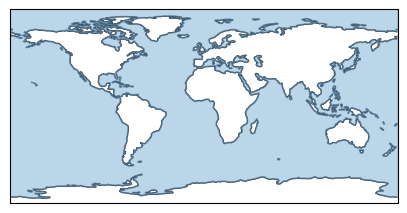

In [1]:
# Plot Starlink backbone topology and demand heatmap

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize, LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def create_grid_boundaries():
    """Create latitude and longitude grid boundaries for 11x11 cells"""
    lat_boundaries = []
    lon_boundaries = []

    lat = 90
    for i in range(11):
        if i < 10:
            lat_boundaries.append((lat, lat - 16))
            lat -= 16
        else:
            lat_boundaries.append((lat, -90))

    lon = -180
    for i in range(11):
        if i < 10:
            lon_boundaries.append((lon, lon + 32))
            lon += 32
        else:
            lon_boundaries.append((lon, 180))

    return lat_boundaries, lon_boundaries

def process_density_data(density_file):
    """Convert raw density data to a 45x90 grid"""
    density_data = np.load(density_file, allow_pickle=True)
    density_grid = np.zeros((45, 90))
    for item in density_data:
        lat_idx = int((90 - item['lat_lon'][0]) // 4)
        lon_idx = int((item['lat_lon'][1] + 180) // 4)
        if lat_idx < 45 and lon_idx < 90:
            density_grid[lat_idx, lon_idx] = item['density']
    return density_grid

def load_data(satellite_data_file):
    """Load traffic, satellite, and coverage data"""
    supply_data = np.load(satellite_data_file, allow_pickle=True)
    satellite_locations = {t: {} for t in range(len(supply_data[0][3]))}
    for idx, data in enumerate(supply_data):
        param, random_numbers, cover, sat_location, _ = data
        for t in range(len(sat_location)):
            satellite_locations[t][idx] = sat_location[t]

    return satellite_locations

def plot_topology(timestamp, satellite_locations, all_inter_topology, all_intra_topology, plot_demands, output_file):
    """Plot satellite topology and demand heatmap at given timestamp"""
    # Define colormap for demand heatmap
    cmap_colors = '#ffffff,#b4d9cc,#89c0b6,#63a6a0,#448c8a,#287274,#0d585f'.split(',')
    color_list = [plt.cm.colors.hex2color(color) for color in cmap_colors]
    norm = Normalize(vmin=0, vmax=16)
    cmap = LinearSegmentedColormap.from_list('custom_map', color_list, N=256)

    fig, ax = plt.subplots(figsize=(5, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m',
                                                edgecolor='face', facecolor='#7BAED5', alpha=0.5))

    # Load demand map
    demand_data = np.load('data/demand_data_backbone.npy', allow_pickle=True).item()
    lats = np.array(demand_data['lat_list'])
    lons = np.array(demand_data['lon_list'])
    values = np.array(demand_data['values'])
    plt.scatter(lons, lats, c=values, cmap=cmap, norm=norm,
                marker='s', s=5, edgecolor='none', alpha=0.75,
                transform=ccrs.PlateCarree())

    def plot_isl_connection(lon1, lat1, lon2, lat2):
        """Draw ISL line, adjusting for dateline crossing"""
        lon1 = ((lon1 + 180) % 360) - 180
        lon2 = ((lon2 + 180) % 360) - 180
        if abs(lon1 - lon2) > 180:
            lon2 += -360 if lon1 < lon2 else 360
        plt.plot([lon1, lon2], [lat1, lat2], color='firebrick', linewidth=1, alpha=0.8,
                 transform=ccrs.PlateCarree())

    # Plot satellite positions
    sat_positions = satellite_locations[timestamp]
    for lon, lat in sat_positions.values():
        lon_deg = np.degrees(lon)
        lat_deg = np.degrees(lat)
        plt.plot(lon_deg, lat_deg, marker='.', markersize=2, transform=ccrs.Geodetic(), color='black')

    # Plot intra-cell ISLs
    for connections in all_intra_topology[timestamp].values():
        for node1, node2 in connections:
            sat1, sat2 = node1 % len(sat_positions), node2 % len(sat_positions)
            if sat1 in sat_positions and sat2 in sat_positions:
                lon1, lat1 = sat_positions[sat1]
                lon2, lat2 = sat_positions[sat2]
                plot_isl_connection(np.degrees(lon1), np.degrees(lat1), np.degrees(lon2), np.degrees(lat2))

    # Plot inter-cell ISLs
    for (node1, node2), _ in all_inter_topology[timestamp]:
        sat1, sat2 = node1 % len(sat_positions), node2 % len(sat_positions)
        if sat1 in sat_positions and sat2 in sat_positions:
            lon1, lat1 = sat_positions[sat1]
            lon2, lat2 = sat_positions[sat2]
            plot_isl_connection(np.degrees(lon1), np.degrees(lat1), np.degrees(lon2), np.degrees(lat2))

    # Add grid lines
    lat_boundaries, lon_boundaries = create_grid_boundaries()
    for lon, _ in lon_boundaries:
        if lon != 180:
            plt.plot([lon, lon], [-90, 90], linestyle='--', color='gray', linewidth=0.5, alpha=0.5,
                     transform=ccrs.PlateCarree())
    for lat, _ in lat_boundaries:
        if lat != -90:
            plt.plot([-180, 180], [lat, lat], linestyle='--', color='gray', linewidth=0.5, alpha=0.5,
                     transform=ccrs.PlateCarree())

    # Add legend and timestamp label
    legend_elements = [
        Line2D([0], [0], marker='.', color='black', label='Satellite', markersize=16, linestyle='None'),
        Line2D([0], [0], color='firebrick', label='ISL', linewidth=4)
    ]
    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.04), ncol=2, fontsize=14)
    time_text = f't = {timestamp * 5} min'
    ax.text(0.95, 0.95, time_text, transform=ax.transAxes,
            ha='right', va='top', fontsize=16,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.tight_layout()
    base_name = output_file.rsplit('.', 1)[0]
    plt.savefig(f"{base_name}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{base_name}.pdf", bbox_inches='tight')
    plt.show()

    print(f"\nTimestamp {timestamp} statistics:")
    print(f"Total inter-cell ISLs: {len(all_inter_topology[timestamp])}")
    print(f"Total intra-cell ISLs: sum({[len(v) for v in all_intra_topology[timestamp].values()]})")

def check_satellite_positions(satellite_locations):
    """Check if any satellite stays in the same position across adjacent time slots"""
    timestamps = sorted(satellite_locations.keys())
    all_satellites = set(satellite_locations[timestamps[0]].keys())
    print(f"\nChecking for static satellites across timestamps...")
    print(f"Total satellites: {len(all_satellites)}")

    for t in range(len(timestamps) - 1):
        static_sats = []
        for sat_id in all_satellites:
            if sat_id in satellite_locations[t] and sat_id in satellite_locations[t + 1]:
                lon1, lat1 = satellite_locations[t][sat_id]
                lon2, lat2 = satellite_locations[t + 1][sat_id]
                if (np.abs(lon1 - lon2) < 1e-3) and (np.abs(lat1 - lat2) < 1e-3):
                    static_sats.append((sat_id, lon1, lat1))
        if static_sats:
            print(f"\nStatic satellites from t={t*5} to t={(t+1)*5} min:")
            for sat_id, lon, lat in static_sats:
                print(f"  Satellite {sat_id}: lon={np.degrees(lon):.2f}°, lat={np.degrees(lat):.2f}°")

# Main
if __name__ == "__main__":

    all_inter_topology = np.load("data/all_inter_topology_573_11_11_distancedt_flow_20.npy", allow_pickle=True).item()
    all_intra_topology = np.load("data/all_intra_topology_573_11_11_distancedt_flow_20.npy", allow_pickle=True).item()

    satellite_locations = load_data(
        "data/TinyLEO_backbone_constellation_satellite.npy",
    )

    plot_demands = np.load("data/plot_demand.npy", allow_pickle=True).item()

    timestamps_to_plot = [0, 5]
    for timestamp in timestamps_to_plot:
        output_file = f"figure16a_{timestamp}"
        plot_topology(timestamp, satellite_locations, all_inter_topology,
                      all_intra_topology, plot_demands, output_file)
        print(f"Generated visualization for timestamp {timestamp}")

    check_satellite_positions(satellite_locations)
